<a href="https://colab.research.google.com/github/SalChem/Accessible-Parking/blob/master/point_detection_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initialize Libraries


In [1]:
#@title
import requests
from pathlib import Path
import json
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool
from bokeh.models import BoxSelectTool
from bokeh.core.properties import Tuple, Float
from bokeh.models.tickers import FixedTicker
from datetime import datetime as dt
import urllib.request
from urllib.parse import urlparse
import os
from IPython.display import clear_output
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import ipywidgets as widgets
import math

from fastai.vision import *
# matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
# matplotlib.rcParams['image.cmap'] = 'gray'
%matplotlib inline

!curl -s https://course.fast.ai/setup/colab | bash
!pip install nbconvert;
!pip install fire ;
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'downloads/'


%load_ext autoreload
%autoreload 2
%matplotlib inline

Updating fastai...
Done.
     |████████████████████████████████| 81kB 3.9MB/s 
  Created wheel for fire: filename=fire-0.2.1-py2.py3-none-any.whl size=103527 sha256=1543ac6d529f40b9f32e046e84a7f076d0196524404064d1f61590d281807dd5
  Stored in directory: /root/.cache/pip/wheels/31/9c/c0/07b6dc7faf1844bb4688f46b569efe6cafaa2179c95db821da
Successfully built fire
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
ls

data@  gdrive/  models@


## Get and prepare Data

In [0]:
#@title
import requests
from pathlib import Path
import json
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool
from bokeh.models import BoxSelectTool
from bokeh.core.properties import Tuple, Float
from bokeh.models.tickers import FixedTicker
from datetime import datetime as dt
import urllib.request
from urllib.parse import urlparse
import os
from IPython.display import clear_output
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import ipywidgets as widgets
import math

from fastai.vision import *
# matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
# matplotlib.rcParams['image.cmap'] = 'gray'
%matplotlib inline

!curl -s https://course.fast.ai/setup/colab | bash
!pip install nbconvert;
!pip install fire ;
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'downloads/'


%load_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
pwd

'/content'

In [0]:
cd '/content/gdrive/My Drive/XSible/'

/content/gdrive/My Drive/XSible


In [0]:
df = pd.read_csv('../xsble_anno.csv')

In [0]:
df.head()

In [0]:
df['cx'] = df.region_shape_attributes.map(lambda r: json.loads(r)['cx'])
df['cy'] = df.region_shape_attributes.map(lambda r: json.loads(r)['cy'])

In [0]:
df.head()

In [0]:
df_all = df.drop(columns=['region_shape_attributes'])

In [0]:
df_all.to_csv("xsble_anno-xy.csv", index=False, encoding='utf8')

## Build Model

In [0]:
#Check for GPU
torch.cuda.is_available()

True

In [0]:
cd '/content/gdrive/My Drive/XSible/raw-dataset-folders/renamed'

/content/gdrive/My Drive/XSible/raw-dataset-folders/renamed


In [0]:
# dataframe we are going to work
# df_all = pd.read_csv("renamed/xsble_anno-xy.csv")
df_all = pd.read_csv("labels.csv")
df_all.head()

,filename,cx,cy
0,img_1.png,68,392
1,img_2.png,434,389
2,img_3.png,46,350
3,img_4.png,426,543
4,img_5.png,501,182


In [0]:
path = Path('/content/gdrive/My Drive/XSible/raw-dataset-folders/renamed');path

PosixPath('/content/gdrive/My Drive/XSible/raw-dataset-folders/renamed')

In [0]:
img_path = f'/content/gdrive/My Drive/XSible/raw-dataset-folders/renamed'
fname = f'img_1.png'

In [0]:
#Read the parking location cx and cy as tuple by passing image file name
def get_ctr(f): 
  return (float(df_all[df_all['filename']==f]['cx'].to_numpy()[0]), float(df_all[df_all['filename']==f]['cy'].to_numpy()[0]))

def get_ctr1(f): 
  f = str(f).split('/')[-1]
  # return tensor(float(df_all[df_all['filename']==f]['cx'].to_numpy()[0]), float(df_all[df_all['filename']==f]['cy'].to_numpy()[0]))
  t = tensor(float(df_all[df_all['filename']==f]['cy'].to_numpy()[0]),float(df_all[df_all['filename']==f]['cx'].to_numpy()[0]))
  return t

#Example 
ctr = get_ctr1(fname) # img_1.png
ctr

tensor([392.,  68.])

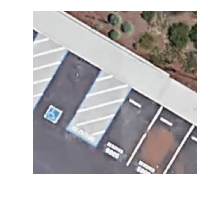

In [0]:
img = open_image(path/fname)
img.show()

In [0]:
#Get ImagePoint
def get_ip(img,pts): 
  return ImagePoints(FlowField(img.size, pts), scale=True)

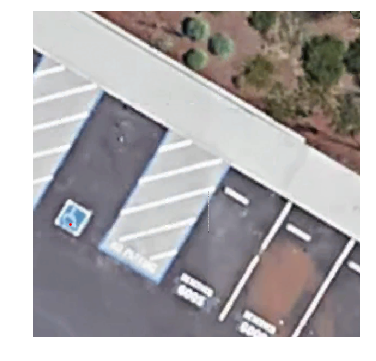

In [0]:
# ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

In [0]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [0]:
# TODO: Fix augmentations
# ds_tfms=get_transforms(max_warp=0)

In [0]:
#data = ImageDataBunch.from_csv(path, ds_tfms=get_transforms(), size=300)
#t = PointsItemList.from_folder(path)
#t2 = t.split_by_rand_pct(valid_pct=0.2)
#t3 = t2.label_from_func(get_ctr1)
# t4 = t3.transform(get_transforms(), tfm_y=True, size=(300,300))
# t5 = t4.databunch()
# t6 = t5.normalize(imagenet_stats)

In [0]:
#doc(t3.transform)

In [0]:
data = (PointsItemList.from_folder(path)
        .split_by_rand_pct(valid_pct=0.2)
        .label_from_func(get_ctr1)
        .transform(get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.0), tfm_y=TfmCoord ,remove_out=False, size=(300,300))
        .databunch(bs=16 ).normalize(imagenet_stats)
       )

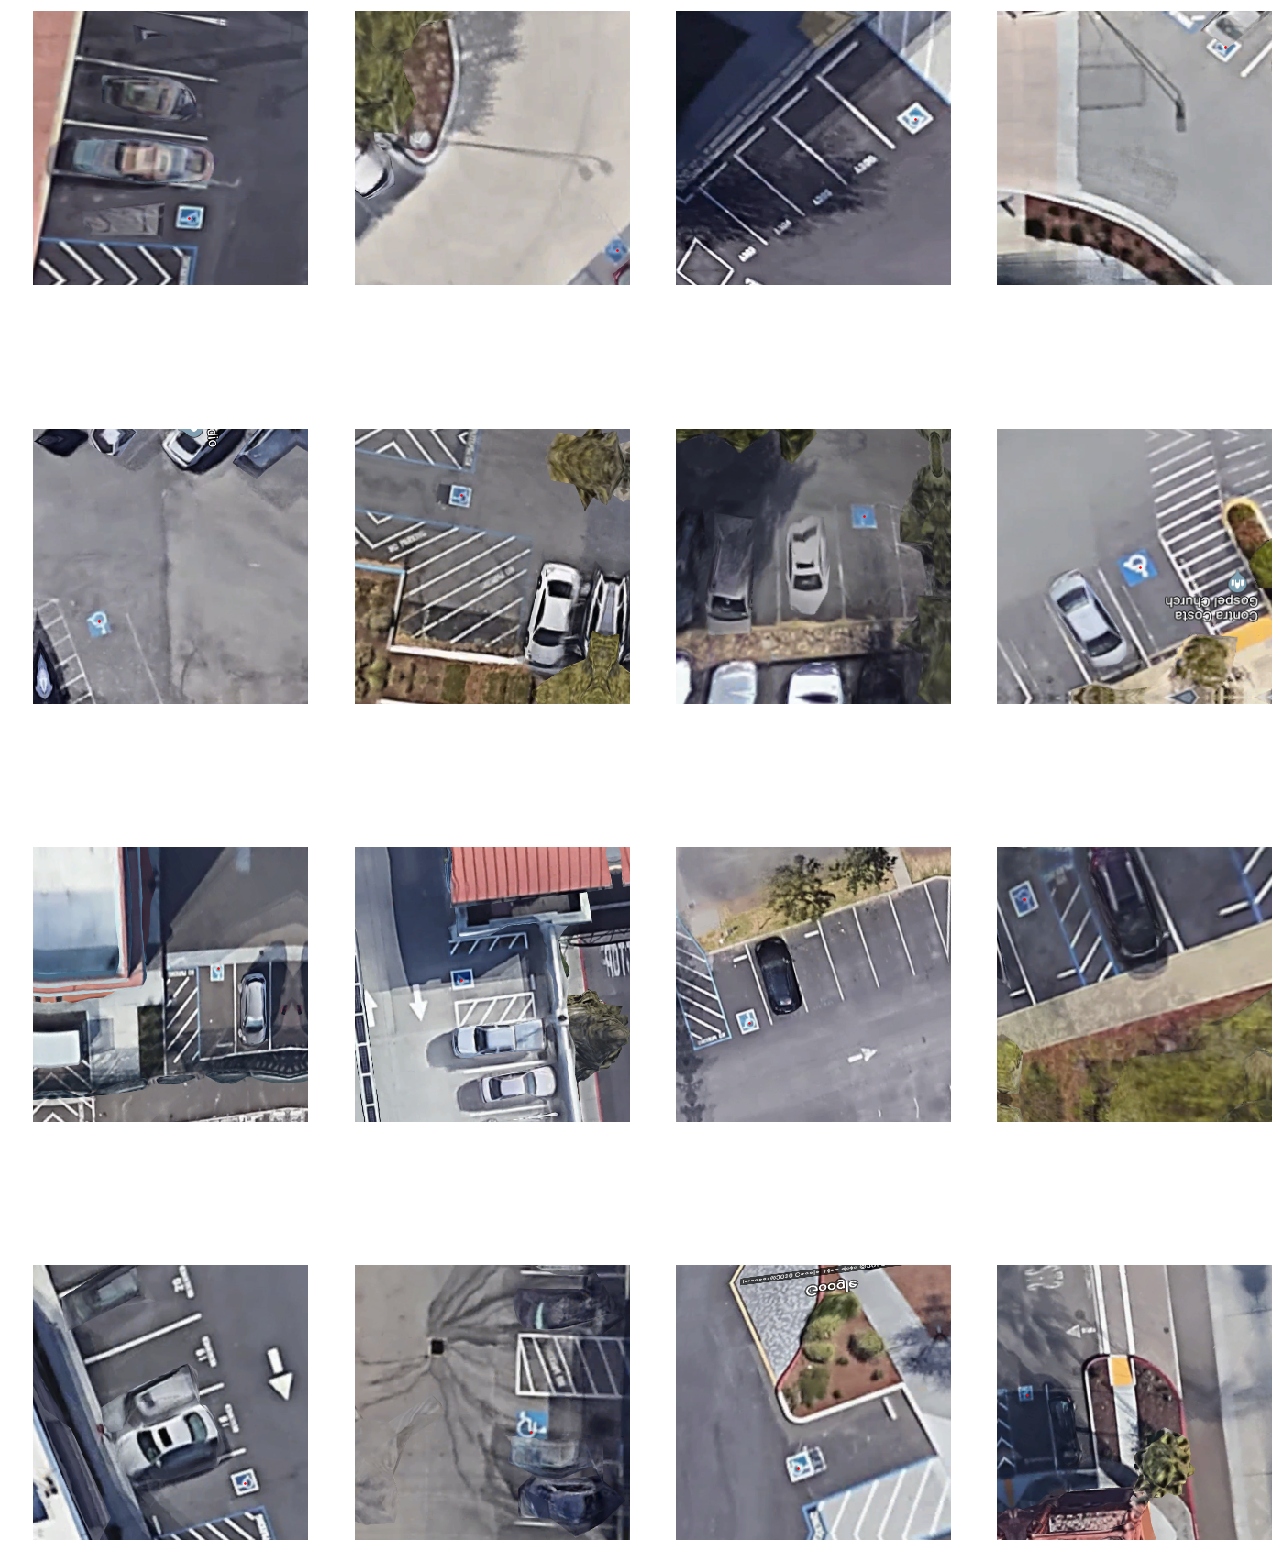

In [0]:
data.show_batch(10, figsize=(18,24))

### Train model

In [0]:
learn = cnn_learner(data, models.resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 110715448.95it/s]


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


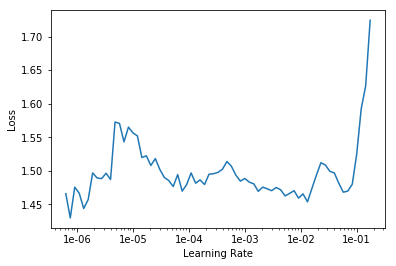

In [0]:
learn.recorder.plot()

In [0]:
lr = 1e-3

In [0]:
learn.fit_one_cycle(30, lr)

epoch,train_loss,valid_loss,time
0,0.943657,0.417359,00:06
1,0.923457,0.399563,00:06
2,0.920785,0.379322,00:06
3,0.861258,0.352587,00:07
4,0.841008,0.352229,00:07
5,0.799009,0.393637,00:06
6,0.777878,0.332624,00:06
7,0.756060,0.321583,00:06
8,0.721836,0.298045,00:07
9,0.683730,0.329265,00:06


In [0]:
learn.loss_func

FlattenedLoss of MSELoss()

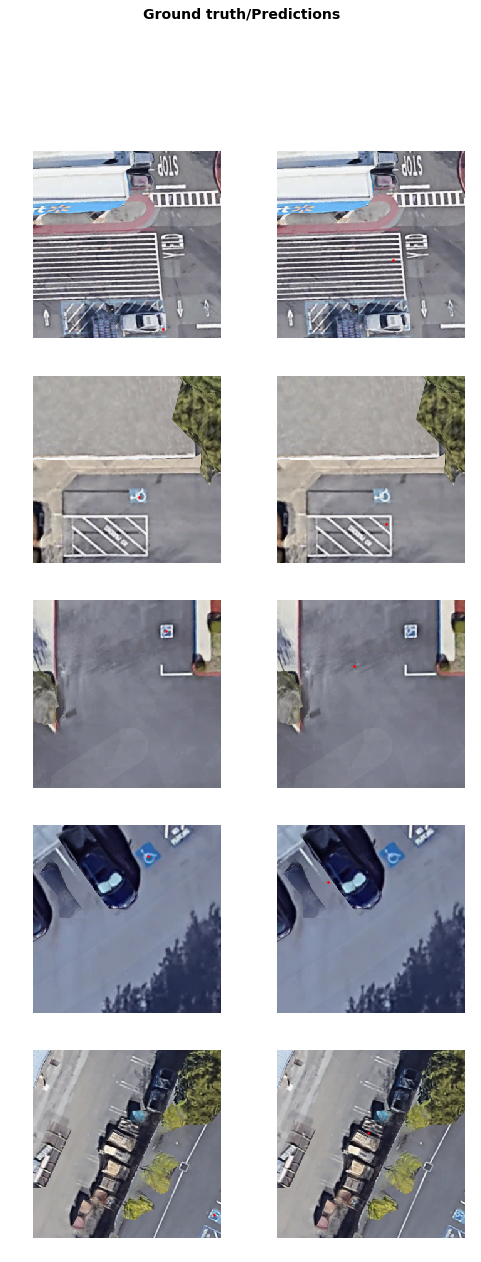

In [0]:
learn.show_results(10)